In [ ]:
from google.colab import drive
drive.mount('Drive')

Mounted at Drive


In [ ]:
from PIL import Image 
from PIL import ImageFilter
from PIL import ImageEnhance
from PIL import ImageOps
import numpy as np
import math
import matplotlib.pyplot as plt
import os

# **Carregando Imagens**

In [ ]:
os.chdir('/content/Drive/MyDrive/PDI/Imagens') # Acessa o diretório da imagem
os.getcwd() # Retorna o diretório atual
os.listdir() # Lista os arquivos do diretório

['DancingInWater.jpg',
 'testpat.1k.color.tif',
 'Shapes.png',
 'fruits.jpg',
 'bruxa.png']

In [ ]:
image = Image.open('DancingInWater.jpg') # Abre a imagem
print('Mode: {0}'.format(image.mode)) # Recupera o espaço de cores utilizado pela imagem
print('Size: {0}'.format(image.size)) # Recupera o tamanho da imagem (pixels)

Mode: RGB
Size: (3000, 2000)


Text(0.5, 1.0, 'Current Image')

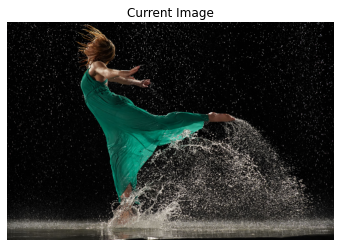

In [ ]:
plt.imshow(image) # Exibe a imagem
plt.axis('off')
plt.title('Current Image')

# **Separando em Canais**

Text(0.5, 1.0, 'Blue')

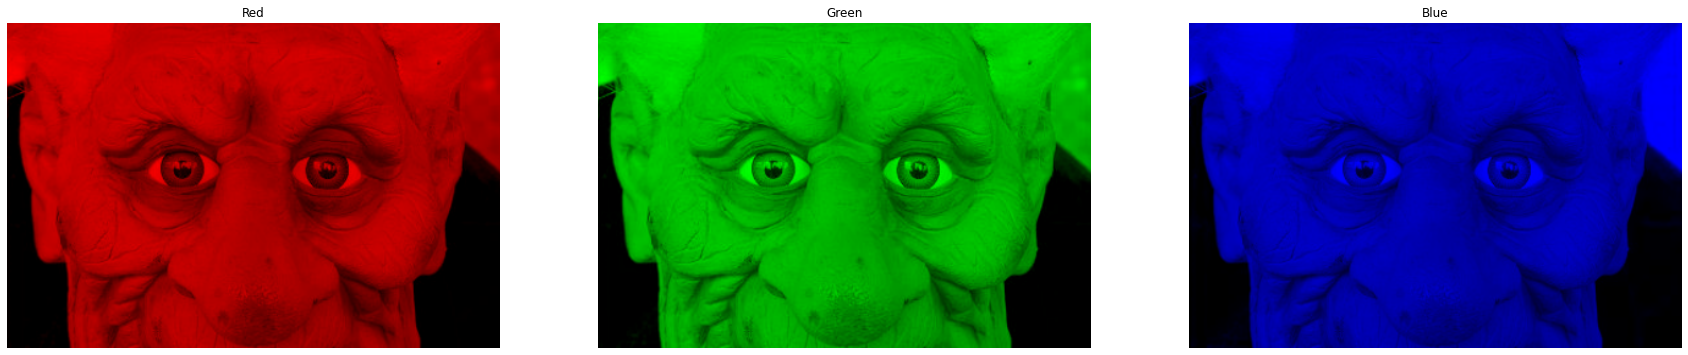

In [ ]:
fig = plt.figure(figsize=(30,10))

# Faço três cópias para cada canal
image_array_red = np.array(image)
image_array_green = np.array(image)
image_array_blue = np.array(image)

fig.add_subplot(1,3,1)

# Zero as componente VERDE e AZUL
image_array_red[:,:,1] *= 0
image_array_red[:,:,2] *= 0
plt.imshow(image_array_red)
plt.axis('off')
plt.title('Red')

fig.add_subplot(1,3,2)

# Zero as componentes VERMELHO e AZUL
image_array_green[:,:,0] *= 0
image_array_green[:,:,2] *= 0
plt.imshow(image_array_green)
plt.axis('off')
plt.title('Green')

fig.add_subplot(1,3,3)

# Zero as componentes VERMELHO e VERDE
image_array_blue[:,:,0] *= 0
image_array_blue[:,:,1] *= 0
plt.imshow(image_array_blue)
plt.axis('off')
plt.title('Blue')

# **RGB-YIQ-RGB**

In [ ]:
def limiter(val):
  if val > 255:
    return 255
  elif val < 0:
    return 0
  
  return val

In [ ]:
def rgb_to_yiq(rgb):
  yiq = np.array(image,dtype=float)

  yiq[:,:,0] = (0.299)*rgb[:,:,0] + (0.587)*rgb[:,:,1] + (0.114)*rgb[:,:,2]
  yiq[:,:,1] = (0.596)*rgb[:,:,0] - (0.274)*rgb[:,:,1] - (0.322)*rgb[:,:,2]
  yiq[:,:,2] = (0.211)*rgb[:,:,0] - (0.523)*rgb[:,:,1] + (0.312)*rgb[:,:,2]

  return yiq

def yiq_to_rgb(yiq):
  rows, columns, components = np.shape(yiq)
  rgb = np.zeros((rows, columns, 3), dtype=int)

  for i in range(rows):
    for j in range(columns):
      rgb[i][j][0] = limiter(yiq[i][j][0] + (0.956)*yiq[i][j][1] + (0.621)*yiq[i][j][2])
      rgb[i][j][1] = limiter(yiq[i][j][0] - (0.272)*yiq[i][j][1] - (0.647)*yiq[i][j][2])
      rgb[i][j][2] = limiter(yiq[i][j][0] - (1.106)*yiq[i][j][1] + (1.703)*yiq[i][j][2])
  
  return rgb

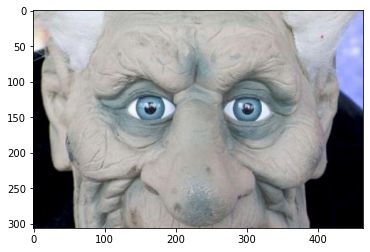

In [ ]:
rgb = np.array(image)
rgb = rgb_to_yiq(rgb)
rgb = yiq_to_rgb(rgb)

plt.imshow(rgb)

# **Negativo**

## **Negativo em RGB**

In [ ]:
def rgb_neg(image_arr):
  image_arr[:,:,0] = 255 - image_arr[:,:,0]
  image_arr[:,:,1] = 255 - image_arr[:,:,1]
  image_arr[:,:,2] = 255 - image_arr[:,:,2]

Text(0.5, 1.0, 'Negative')

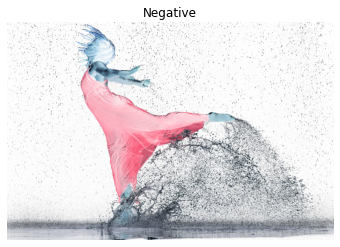

In [ ]:
image_arr = np.array(image)
rgb_neg(image_arr)

plt.imshow(image_arr)
plt.axis('off')
plt.title('Negative')

## **Negativo em YIQ**

In [ ]:
def yiq_neg(rgb):
  yiq = rgb_to_yiq(rgb)

  yiq[:,:,0] = 255 - yiq[:,:,0]

  return yiq_to_rgb(yiq)

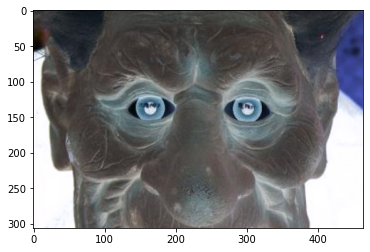

In [ ]:
rgb = np.array(image)

rgb = yiq_neg(rgb)

plt.imshow(rgb)

# **Filtro**

In [ ]:
def zero_extension(image_arr, r_filter, c_filter, pivot_row, pivot_column):
  rows, columns = np.shape(image_arr)
  
  zero_row_add = (r_filter - 1)//2
  zero_column_add = (c_filter - 1)//2

  '''
    Descobrimos qual das componentes do pivô possui maior relevância
  '''
  pivot_row -= zero_row_add
  pivot_column -= zero_column_add

  if pivot_row < 0:
    pivot_row *= -1
  elif pivot_column < 0:
    pivot_column *= -1

  # Recuperamos qual o maior valor de relevância (linha ou coluna do pivô)
  result = max(pivot_row, pivot_column)

  '''
     Adicionamos ao número de linhas e colunas o valor de relevância que a posição do pivô possui
     na adição de linhas e colunas com zero
  '''
  zero_row_add += result
  zero_column_add += result

  '''
    rows = número de linhas na matriz original
    zero_column_add = número de colunas a serem adicionadas
  '''
  zero_column = np.zeros((rows,zero_column_add))  # (COLUNA) 
                
  image_arr = np.append(zero_column, image_arr, axis = 1) # coluna antes
  image_arr = np.append(image_arr, zero_column, axis = 1) # colunas depois

  '''
    zero_row_add = número de linhas a serem adicionadas
    columns + zero_column_add * 2 = número de colunas na matriz original + (número de colunas a serem adicionadas * 2), multiplicamos por 2 pois é em cima e em baixo
  '''
  zero_line = np.zeros((zero_row_add, columns + zero_column_add * 2))# (LINHA) 
  image_arr = np.append(zero_line, image_arr, axis = 0) # linha antes
  image_arr = np.append(image_arr, zero_line, axis = 0) # linha depois

  return (image_arr, zero_row_add, zero_column_add)

In [ ]:
'''TESTES
arr = np.array([[1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4], [1,1,2,3,4]])

print(arr)

arr = zero_extension(arr,  5,3,0,0)
print()

print(arr)
'''

[[1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]
 [1 1 2 3 4]]

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 1., 1., 2., 3., 4., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 4, 3)


In [ ]:
def median_filter(image_array, r_filter, c_filter, pivot_row, pivot_column):
  result_image = image_array.copy()
  
  image_array, rows_add, columns_add = zero_extension(image_array, r_filter, c_filter, pivot_row, pivot_column)
  rows, columns = np.shape(image_array)
  
  for i in range(rows_add, rows - rows_add):
    for j in range(columns_add, columns - columns_add):
      filter_shape = []
      
      for m in range(i - pivot_row, i + (r_filter - pivot_row)):
        for n in range(j - pivot_column, j + (c_filter - pivot_column)):
          filter_shape.append(image_array[m][n])
      
      filter_shape.sort()
      result_image[i - rows_add][j - columns_add] = filter_shape[len(filter_shape)//2]
  
  return result_image

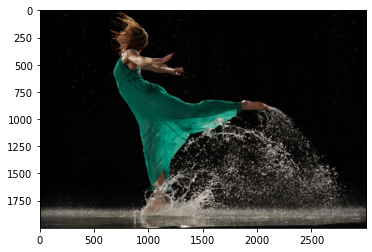

In [ ]:
image_array = np.array(image)

image_array[:,:,0] = median_filter(image_array[:,:,0], 9 ,9 , 4, 4)
image_array[:,:,1] = median_filter(image_array[:,:,1], 9 ,9 , 4, 4)
image_array[:,:,2] = median_filter(image_array[:,:,2], 9 ,9 , 4, 4)

plt.imshow(image_array)

# **RGB-HSB-RGB**

In [ ]:
def